In [1]:
import os
from io import BytesIO
import pickle
import torch
import tensorflow.compat.v1 as tf
import math.ceil
tf.enable_eager_execution()

# CONFIG
data_path = os.getcwd() + "/data/training/"


In [2]:
def load_blob(blob_idx):
    with open(f'{data_path}/blob_{blob_idx}.pickle', 'rb') as f:
        # Load the 'data' dictionary using the highest protocol available.
        return pickle.load(f)

In [3]:
blob = load_blob(1)

In [4]:
blob[0].keys()

dict_keys(['FRONT', 'FRONT_LEFT', 'SIDE_LEFT', 'FRONT_RIGHT', 'SIDE_RIGHT', 'context'])

In [20]:
import numpy as np
# torch.tensor(np.array(bytearray(blob[0]['SIDE_RIGHT']['image']))).shape
img = tf.image.decode_jpeg(blob[0]['SIDE_RIGHT']['image'])

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [38]:
x_pixels, y_pixels = torch.tensor(img.numpy()).shape[0], torch.tensor(img.numpy()).shape[1]

In [525]:
x_pixels

886

In [526]:
y_pixels

1920

In [412]:
labeled_boxes = blob[0]['SIDE_RIGHT']['labels'].labels

(-0.5, 1919.5, 885.5, -0.5)

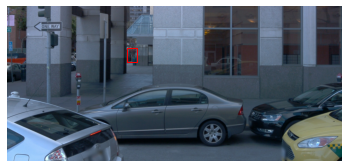

In [414]:
ax = plt.subplot()
for label in [labeled_boxes[0]]:
    # Draw the object bounding box.
    ax.add_patch(patches.Rectangle(
    xy=(label.box.center_x - 0.5 * label.box.length,
        label.box.center_y - 0.5 * label.box.width),
    width=label.box.length,
    height=label.box.width,
    linewidth=1,
    edgecolor='red',
    facecolor='none'))
plt.imshow(torch.tensor(img.numpy()))
plt.axis('off')

(-0.5, 1919.5, 885.5, -0.5)

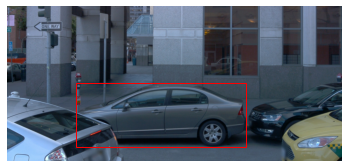

In [435]:
labeled_box = blob[0]['SIDE_RIGHT']['labels'].labels[2]
ax = plt.subplot()
ax.add_patch(patches.Rectangle(
xy=(labeled_box.box.center_x - 0.5 * labeled_box.box.length,
    labeled_box.box.center_y - 0.5 * labeled_box.box.width),
width=labeled_box.box.length,
height=labeled_box.box.width,
linewidth=1,
edgecolor='red',
facecolor='none'))
plt.imshow(imag)
plt.axis('off')

In [540]:
centre_x = blob[0]['SIDE_RIGHT']['labels'].labels[2].box.center_x
centre_y = blob[0]['SIDE_RIGHT']['labels'].labels[2].box.center_y
height = blob[0]['SIDE_RIGHT']['labels'].labels[2].box.width
depth = blob[0]['SIDE_RIGHT']['labels'].labels[2].box.length
img = tf.image.decode_jpeg(blob[0]['SIDE_RIGHT']['image'])
imag = torch.tensor(img.numpy())
x_pixels, y_pixels = imag.shape[0], imag.shape[1]
heat_maps = torch.zeros((4, x_pixels, y_pixels))
object_type = blob[0]['SIDE_RIGHT']['labels'].labels[2].type

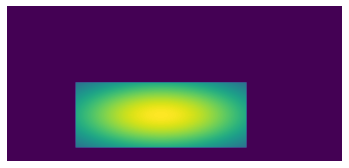

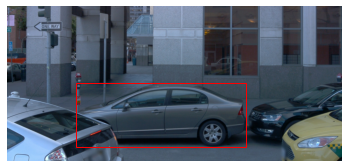

In [547]:
get_heat(centre_x, centre_y, height, depth, object_type, heat_maps, imag)

In [546]:
def get_heat(centre_x, centre_y, height, depth, obect_type, heat_maps, img):
    top_left = (max(0, int(centre_x - 0.5*depth)), 
                max(0, int(centre_y - 0.5*height)))
    bottom_right = (min(heat_maps.shape[2]-1, math.ceil(centre_x + 0.5*depth + 1)), 
                    min(heat_maps.shape[1]-1, math.ceil(centre_y + 0.5*height + 1)))

    x,y = np.meshgrid(np.arange(top_left[0], bottom_right[0]),
                      np.arange(top_left[1], bottom_right[1]))
    pos = np.dstack((x,y))
    mean = np.array([centre_x, centre_y])
    cov  = np.array([[depth**2/4,0],[0,height**2/4]])

    rv = multivariate_normal(mean,cov)
    z = rv.pdf(pos)

    heat_maps[object_type, top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = torch.tensor(z)

    plt.imshow(heat_maps[object_type])
    plt.axis('off')
    
    ##### To compare ######
    plt.figure()
    labeled_box = blob[0]['SIDE_RIGHT']['labels'].labels[2]
    ax = plt.subplot()
    ax.add_patch(patches.Rectangle(
    xy=(labeled_box.box.center_x - 0.5 * labeled_box.box.length,
        labeled_box.box.center_y - 0.5 * labeled_box.box.width),
    width=labeled_box.box.length,
    height=labeled_box.box.width,
    linewidth=1,
    edgecolor='red',
    facecolor='none'))
    plt.imshow(imag)
    plt.axis('off')
    return 